In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product as product
%matplotlib notebook

In [125]:
# Every time it passes a multiple of 20, make the c_t factor equal to 0.4
# If the number of infectives decreases by 10, make the c_t factor equal to 1
def doobGillespie_old(diagonal, currState, Pjump, biStates):
    times = [(0, biStates[currState])]
    state = currState
    while biStates[state][1] != 0: # While the number of infectives isn't zero
        timeSpent = np.random.exponential(scale=1/(diagonal[state]))
        state = np.random.choice(range(Pjump.shape[1]), p=Pjump[state, :])
        times.append((times[-1][0] + timeSpent, biStates[state]))
    return times

def doobGillespie_v1(diagonal, diagonalDist, currState, Pjump, PjumpDist, biStates, N):
    distancing = False
    times = [(0, biStates[currState])]
    state = currState
    old = biStates[state][0] # num of susceps
    distancingTime = []
    while biStates[state][1] != 0: # While the number of infectives isn't zero
        if distancing:
            # print("distancing")
            timeSpent = np.random.exponential(scale=1/(diagonalDist[state]))
            state = np.random.choice(range(Pjump.shape[1]), p=PjumpDist[state, :])
            times.append((times[-1][0] + timeSpent, biStates[state]))
            if biStates[state][1] <= 5: # if the number of infectives goes below 5, relax restrictions
                distancing = False
                old = biStates[state][0]
                distancingTime.append(times[-1][0])
        else:     
            timeSpent = np.random.exponential(scale=1/(diagonal[state]))
            state = np.random.choice(range(Pjump.shape[1]), p=Pjump[state, :])
            times.append((times[-1][0] + timeSpent, biStates[state]))
            if old - biStates[state][0] >= 10:
                # print("start distancing")
                distancingTime.append(times[-1][0])
                distancing = True
                oldInf = biStates[state][1]
    return times, distancingTime

def doobGillespie_v2(diagonal, diagonalDist, currState, Pjump, PjumpDist, biStates, N):
    distancing = False
    times = [(0, biStates[currState])]
    state = currState
    old = biStates[state][0] # num of susceps
    distancingTime = []
    while biStates[state][1] != 0: # While the number of infectives isn't zero
        if distancing:
            # print("distancing")
            timeSpent = np.random.exponential(scale=1/(diagonalDist[state]))
            state = np.random.choice(range(Pjump.shape[1]), p=PjumpDist[state, :])
            times.append((times[-1][0] + timeSpent, biStates[state]))
        else:     
            timeSpent = np.random.exponential(scale=1/(diagonal[state]))
            state = np.random.choice(range(Pjump.shape[1]), p=Pjump[state, :])
            times.append((times[-1][0] + timeSpent, biStates[state]))
            if old - biStates[state][0] >= 10:
                # print("start distancing")
                distancingTime.append(times[-1][0])
                distancing = True
                oldInf = biStates[state][1]
    return times, distancingTime

In [126]:
N = 100
I_0 = 5
Rsi = 2/N
Rir = 1/N

states = {(x, y) : ind for ind, (x, y) in enumerate([(x, y) for x in range(N + 1) for y in range(N + 1) if x + y <= N], 0)}
biStates = {ind : state for state, ind in states.items()}

In [160]:
def getQMatrix(states, ct=1):
    Q = np.zeros((len(states), len(states)))

    for (x, y), ind in states.items():
        if y > 0:
            transitionTo = states[(x, y - 1)]
            Q[ind, transitionTo] = Rir * y
        if x > 0:
            transitionTo = states[(x - 1, y + 1)]
            Q[ind, transitionTo] = Rsi * y * x * ct
        Q[ind, ind] = - np.sum(Q[ind, :])
    
    diagonal = (- np.diagonal(Q))
    Pjump = Q / (- np.diagonal(Q))[:, np.newaxis]
    np.fill_diagonal(Pjump, 0)
    np.nan_to_num(Pjump, copy=False)
    return Q, Pjump, diagonal

Q, Pjump, diagonal = getQMatrix(states)
DistQ, PjumpDist, diagonalDist = getQMatrix(states, ct=0.006)

# check = np.sum(Pjump, axis=1)
# assert np.allclose(check, np.sum(PjumpDist, axis=1))

# for i in range(len(check)):
#     if check[i] == 0:
#         print(biStates[i])

# ct = 0.01
# DistQ = np.zeros((len(states), len(states)))
# for (x, y), ind in states.items():
#     if y > 0:
#         transitionTo = states[(x, y - 1)]
#         DistQ[ind, transitionTo] = Rir * y
#     if x > 0:
#         transitionTo = states[(x - 1, y + 1)]
#         DistQ[ind, transitionTo] = Rsi * y * x * ct
#     DistQ[ind, ind] = - np.sum(DistQ[ind, :])

# diagonalDist = (- np.diagonal(DistQ))
# PjumpDist = DistQ / (- np.diagonal(DistQ))[:, np.newaxis]
# np.fill_diagonal(PjumpDist, 0)
# np.nan_to_num(PjumpDist, copy=False)

C:\Users\Aviral\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


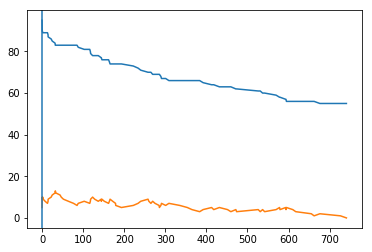

In [162]:
trace, distancingTime = doobGillespie_v2(diagonal, diagonalDist, states[(N - I_0, I_0)], Pjump, PjumpDist, biStates, N)
traceTimes, traceStates = zip(*trace)
traceSuscep, traceInf = zip(*traceStates)

# Plotting the trajectories
plt.figure()
plt.plot(traceTimes, traceSuscep, label="Susceptibles")
plt.plot(traceTimes, traceInf, label="Susceptibles")

for i in distancingTime:
    plt.axvline(i)

plt.show()

In [163]:
print(distancingTime)
trace

[0.4436914641645085]


[(0, (95, 5)),
 (0.17104351298639545, (94, 6)),
 (0.21719342024216254, (93, 7)),
 (0.2624159775725743, (92, 8)),
 (0.34195512777358095, (91, 9)),
 (0.4436914641645085, (90, 10)),
 (0.572486975773779, (90, 9)),
 (1.662049527390797, (89, 10)),
 (2.7753486111957373, (89, 9)),
 (7.450146473388054, (89, 8)),
 (13.265051833611656, (89, 7)),
 (14.65008440758268, (88, 8)),
 (14.769821918565981, (87, 9)),
 (22.197270040762177, (86, 10)),
 (24.7787674013777, (85, 11)),
 (31.66274806368837, (84, 12)),
 (32.275967235412864, (83, 13)),
 (33.71180289264868, (83, 12)),
 (43.82272058686598, (83, 11)),
 (46.69960524358392, (83, 10)),
 (52.01037378326334, (83, 9)),
 (64.11964770536414, (83, 8)),
 (76.60978908767741, (83, 7)),
 (85.15521054070021, (83, 6)),
 (88.11901125423586, (82, 7)),
 (102.61678352863552, (81, 8)),
 (116.14988718079263, (81, 7)),
 (117.5714773419179, (80, 8)),
 (118.22351420172818, (79, 9)),
 (123.0387098906144, (78, 10)),
 (128.0936774514183, (78, 9)),
 (136.82564682646833, (78, 8))

In [170]:
funcs = [doobGillespie_v2]
params = {
    doobGillespie_v1.__name__ : [diagonal, diagonalDist, states[(N - I_0, I_0)], Pjump, PjumpDist, biStates, N],
    doobGillespie_v2.__name__ : [diagonal, diagonalDist, states[(N - I_0, I_0)], Pjump, PjumpDist, biStates, N]
    } 

distribution = np.zeros((len(funcs), N - I_0 + 1))

endTimes = [0]

for func_ind, func in enumerate(funcs, 0):
    trials = int(1e4)
    infected = [0 for i in range(N - I_0 + 1)]
    # What does the distribution for this function look like
    for trial in range(trials):
        trace, _ = func(*params[func.__name__])
        endState = trace[-1][1]
        endTimes[func_ind] += trace[-1][0]
        suscepInfected = (N - I_0) - endState[0]
        infected[suscepInfected] += 1
    
    distribution[func_ind, :] = np.asarray([i/trials for i in infected])
    endTimes[func_ind] /= trials

Text(0, 0.5, 'Probability')

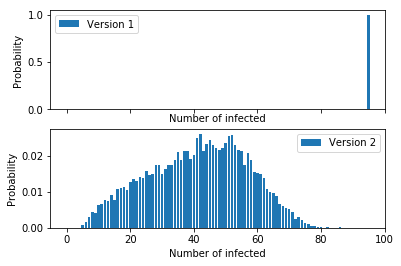

In [171]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].bar(range(N - I_0 + 1), distribution[0, :], label="Version 1")
ax[0].legend()
ax[0].set_xlabel("Number of infected")
ax[0].set_ylabel("Probability")

ax[1].bar(range(N - I_0 + 1), distribution[1, :], label="Version 2")
ax[1].legend()
ax[1].set_xlabel("Number of infected")
ax[1].set_ylabel("Probability")